In [ ]:
# Project Title: Skin Cancer Classification with Transfer Learning

# This project uses a Convolutional Neural Network (CNN) based on Transfer Learning to classify skin lesions into benign and malignant categories.
# The dataset used is the ISIC 2018 dataset, a widely recognized benchmark in skin cancer research.

In [ ]:
# Import libraries

# General-purpose libraries
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Deep learning (TensorFlow & Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Scikit-learn for preprocessing & evaluation
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from itertools import cycle

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# If running locally or in Colab, upload your kaggle.json here:
from google.colab import files
files.upload()  # Upload kaggle.json manually

# Or manually place kaggle.json in ~/.kaggle/ if you are running in a prepared environment
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')  # Uncomment if using upload method
os.chmod('/root/.kaggle/kaggle.json', 600)

# Download and unzip the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d ./skin_cancer_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [03:31<00:01, 14.3MB/s]
100% 5.20G/5.20G [03:31<00:00, 26.4MB/s]


In [ ]:
# Load metadata CSV file

df = pd.read_csv('./skin_cancer_data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


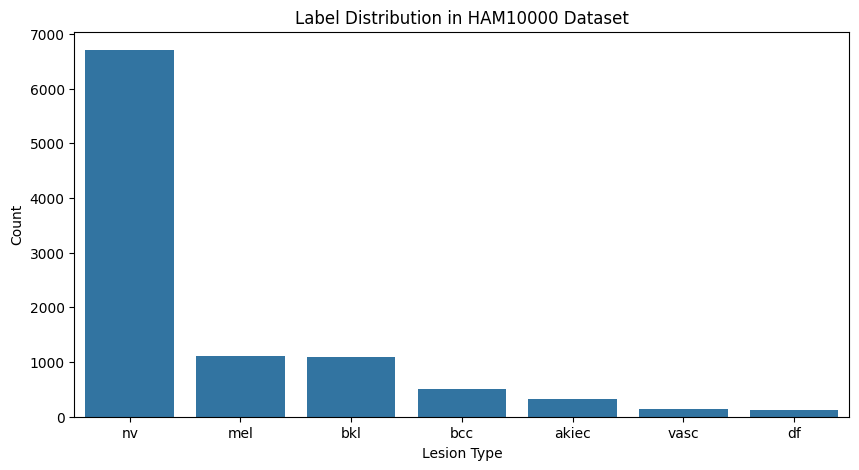

In [ ]:
# Label distribution visualization

plt.figure(figsize=(10, 5))
sns.countplot(df, x='dx', order=df['dx'].value_counts().index)
plt.title("Label Distribution in HAM10000 Dataset")
plt.xlabel("Lesion Type")
plt.ylabel("Count")
plt.show()

In [ ]:
# Map short labels to full lesion names

lesion_labels = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion_type'] = df['dx'].map(lesion_labels)

Lesion Type Distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


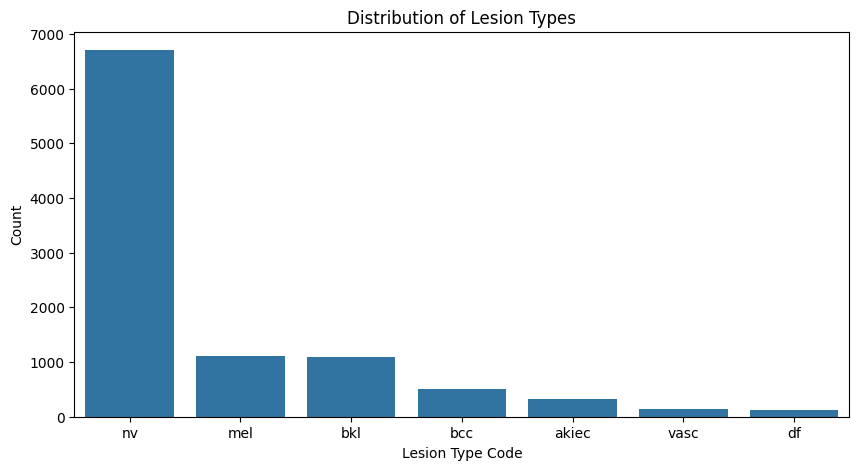

In [ ]:
# Show class distribution
label_counts = df['dx'].value_counts()
print("Lesion Type Distribution:")
print(label_counts)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Lesion Types")
plt.xlabel("Lesion Type Code")
plt.ylabel("Count")
plt.show()

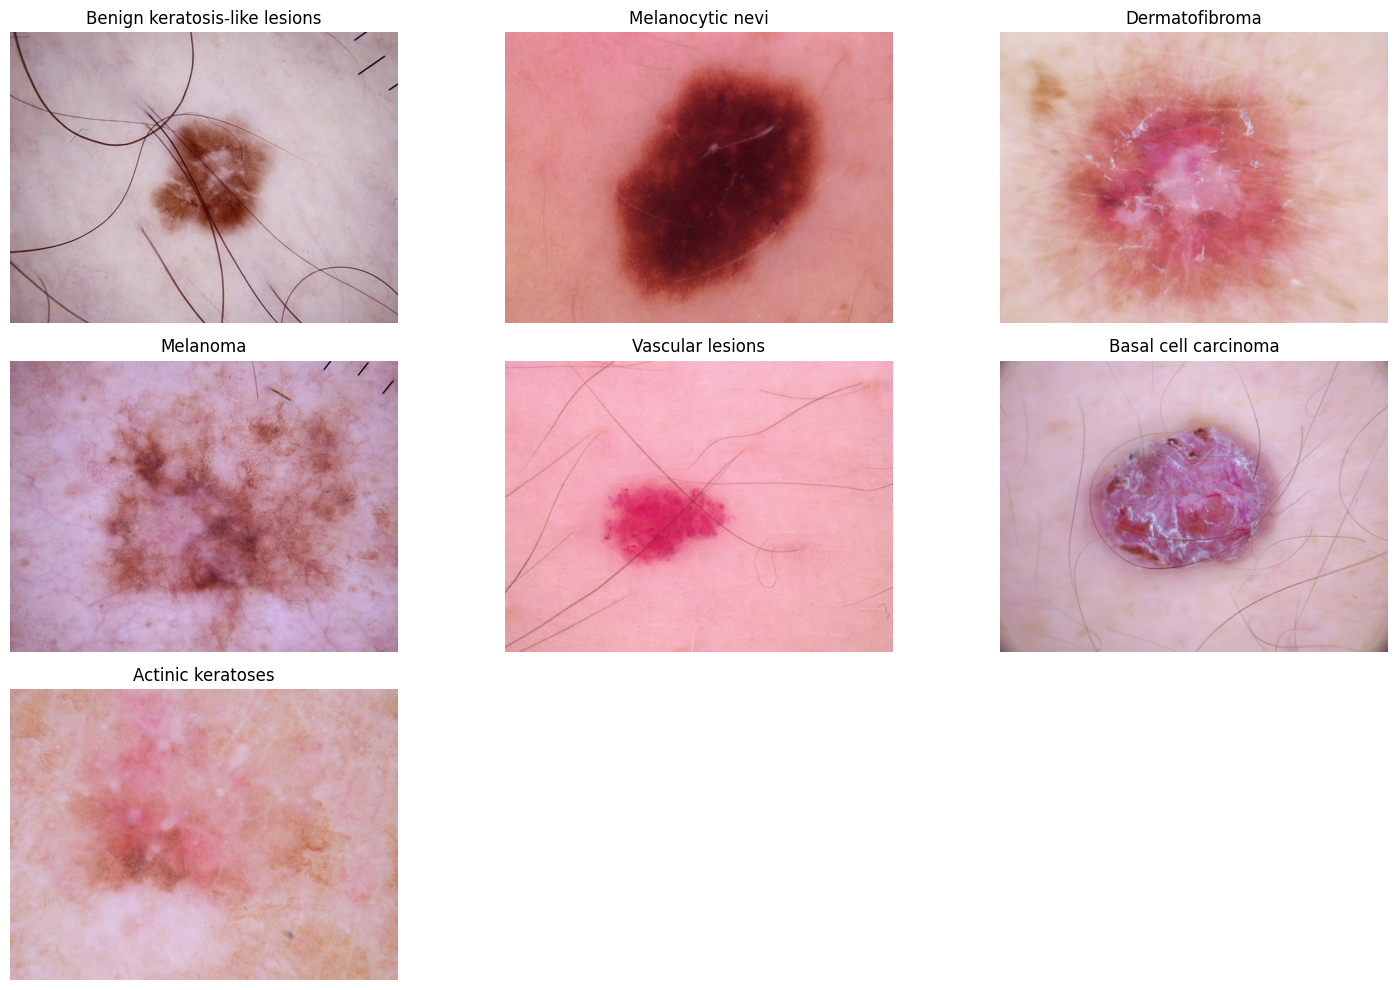

In [ ]:
# Show one sample image per lesion type class

image_dirs = [
    './skin_cancer_data/HAM10000_images_part_1/',
    './skin_cancer_data/HAM10000_images_part_2/'
]

classes = df['lesion_type'].unique()

plt.figure(figsize=(15, 10))
for i, lesion in enumerate(classes):
    sample = df[df['lesion_type'] == lesion].sample(1).iloc[0]
    image_filename = sample['image_id'] + '.jpg'

    for dir_path in image_dirs:
        image_path = os.path.join(dir_path, image_filename)
        if os.path.exists(image_path):
            img = mpimg.imread(image_path)
            break
    else:
        print(f"Image {image_filename} not found in either directory.")
        continue

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Encode lesion type labels as integers

le = LabelEncoder()
df['label'] = le.fit_transform(df['lesion_type'])
df[['lesion_type', 'label']].head()

,lesion_type,label
0,Benign keratosis-like lesions,2
1,Benign keratosis-like lesions,2
2,Benign keratosis-like lesions,2
3,Benign keratosis-like lesions,2
4,Benign keratosis-like lesions,2


In [ ]:
# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Check class distribution
print("Train distribution:\n", train_df['label'].value_counts())
print("\nTest distribution:\n", test_df['label'].value_counts())

Train distribution:
 label
4    5364
5     890
2     879
1     411
0     262
6     114
3      92
Name: count, dtype: int64

Test distribution:
 label
4    1341
5     223
2     220
1     103
0      65
6      28
3      23
Name: count, dtype: int64


In [ ]:
# Preprocess images: resize and normalize

IMAGE_SIZE = (128, 128)
image_dirs = [
    './skin_cancer_data/HAM10000_images_part_1/',
    './skin_cancer_data/HAM10000_images_part_2/'
]

def preprocess_images(df):
    images = []
    labels = []

    for i in tqdm(range(len(df))):
        filename = df['image_id'].iloc[i] + '.jpg'
        for dir_path in image_dirs:
            path = os.path.join(dir_path, filename)
            if os.path.exists(path):
                img = load_img(path, target_size=IMAGE_SIZE)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(df['label'].iloc[i])
                break
        else:
            print(f"Image {filename} not found in any directory.")
            continue

    return np.array(images), np.array(labels)

X_train, y_train = preprocess_images(train_df)
X_test, y_test = preprocess_images(test_df)

100%|██████████| 2003/2003 [00:14<00:00, 139.34it/s]


In [ ]:
# Encode labels as one-hot vectors

num_classes = len(np.unique(y_train))

y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

In [ ]:
# Build the Transfer Learning model using MobileNetV2

input_shape = (128, 128, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model

history = model.fit(X_train, y_train_encoded,
                    validation_data=(X_test, y_test_encoded),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.6270 - loss: 1.1937 - val_accuracy: 0.7279 - val_loss: 0.7638
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7257 - loss: 0.7813 - val_accuracy: 0.7439 - val_loss: 0.7296
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7480 - loss: 0.7185 - val_accuracy: 0.7484 - val_loss: 0.6988
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7618 - loss: 0.6522 - val_accuracy: 0.7454 - val_loss: 0.7039
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7598 - loss: 0.6493 - val_accuracy: 0.7544 - val_loss: 0.6874
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7700 - loss: 0.6315 - val_accuracy: 0.7449 - val_loss: 0.7321
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7761 - loss: 0.6126 - val_accuracy: 0.7514 - val_loss: 0.6931
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7772 - loss: 0.6166 - val_acc

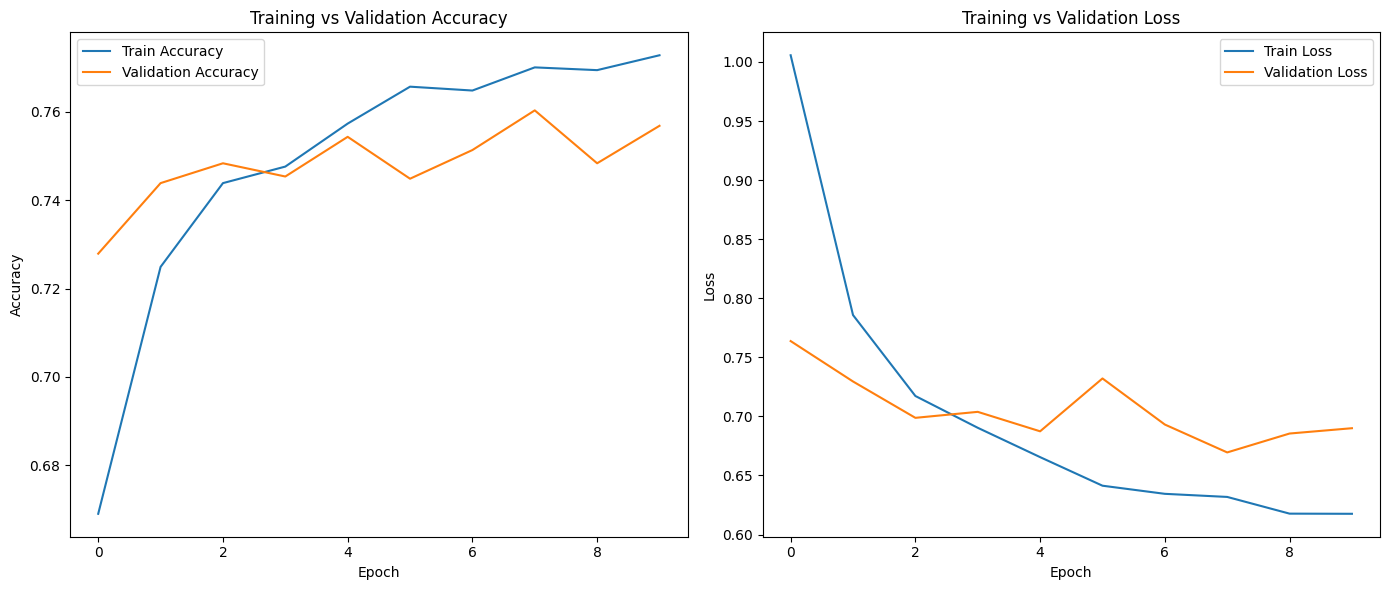

In [ ]:
# Plot training and validation accuracy & loss
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step


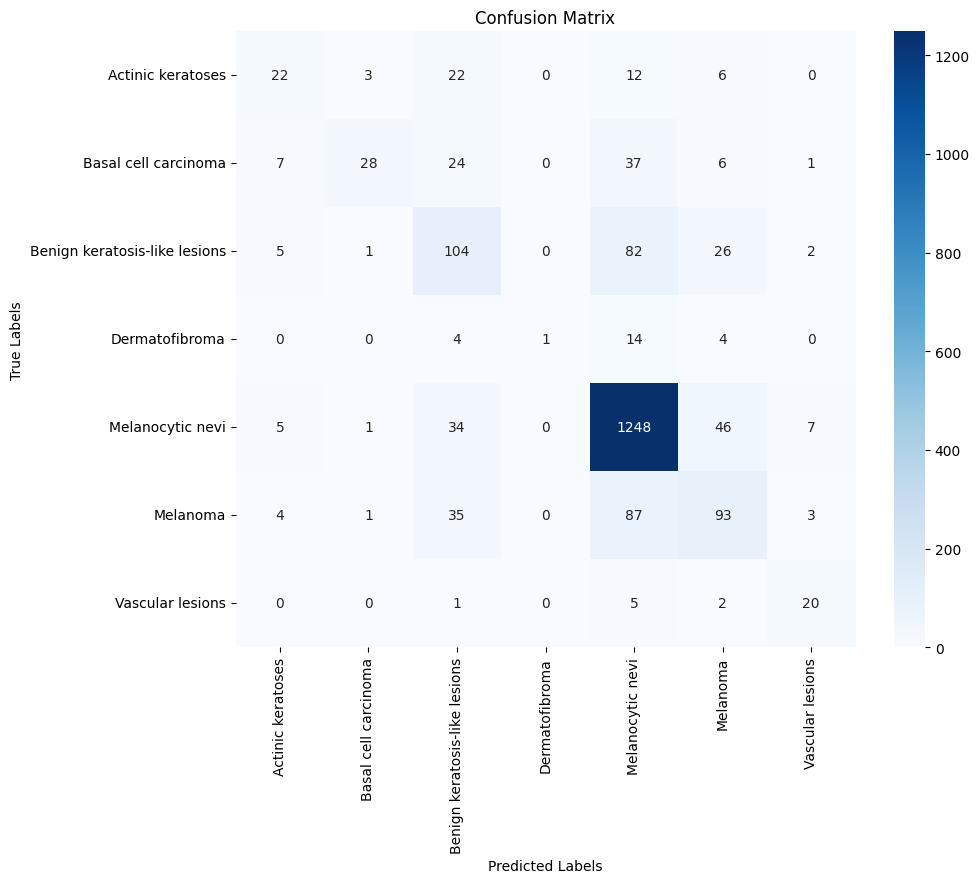

                               precision    recall  f1-score   support

            Actinic keratoses       0.51      0.34      0.41        65
         Basal cell carcinoma       0.82      0.27      0.41       103
Benign keratosis-like lesions       0.46      0.47      0.47       220
               Dermatofibroma       1.00      0.04      0.08        23
             Melanocytic nevi       0.84      0.93      0.88      1341
                     Melanoma       0.51      0.42      0.46       223
             Vascular lesions       0.61      0.71      0.66        28

                     accuracy                           0.76      2003
                    macro avg       0.68      0.46      0.48      2003
                 weighted avg       0.75      0.76      0.74      2003



In [ ]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

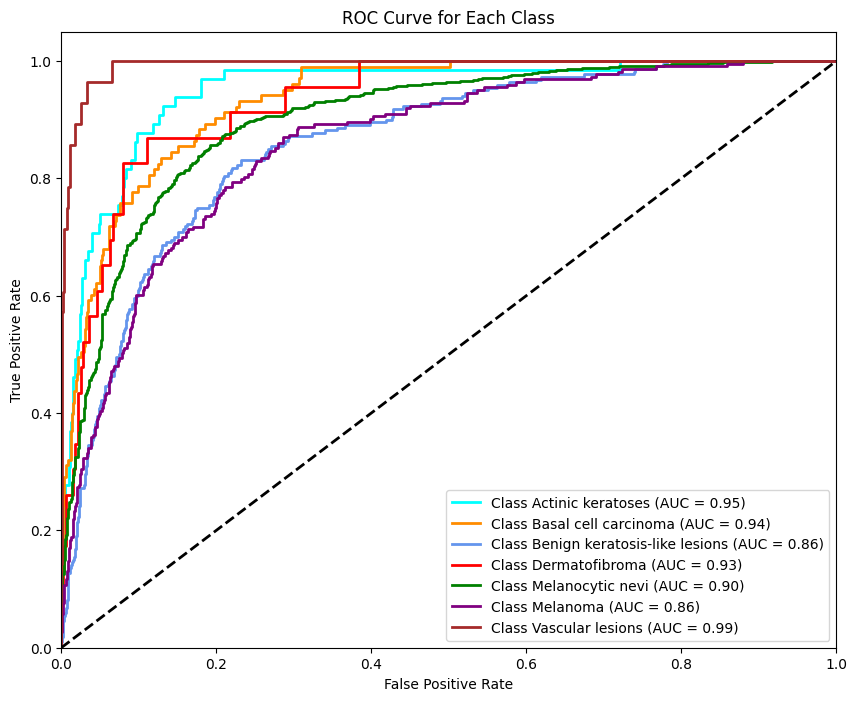

In [ ]:
# Binarize labels for ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()